In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tabulate import tabulate as tab
import types # to use dictionary as an object

# !pip3 install torch torchvision 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# !pip3 install umap-learn
# import umap

#!pip3 install plotly
import plotly.graph_objects as go # interactive plots

# synthData_path = os.path.join('..', 'synthetic_data') 
# sys.path.append(synthData_path)
# import generate_synthetic_data as gsd

import gmvae_architecture as ga
import gmvae_performance_and_validation as gpv


# Read Synthetic Datasets

In [2]:
# noise_level = 0.0
# noise_level = 0.001
# noise_level = 0.01
noise_level = 0.05

In [3]:
data = np.load(f"../synthetic_data/synthetic_training_allCases_120k_noise_{noise_level}.npz")

X_train = data["X"]
Y_train = data["y"]
shifts_pileup_train = data["meta"]

In [4]:
data = np.load(f"../synthetic_data/synthetic_test_allCases_480k_noise_{noise_level}.npz")

X_test = data["X"]
Y_test = data["y"]
shifts_pileup_test = data["meta"]

# Minimal GMVAE: Training

In [5]:
# model parameters
config_dict = {
    "L": X_train.shape[1],   # waveform length (296 in paper)
    "z_dim": 8,              # latent dimension 
    "alpha": 50,             # classification weight in the loss (50 in paper)
    "batch_size": 128,       # 100 in paper
    "epochs": 50,            # 100 in paper
    "learning_rate": 1e-3,   # 1e-4 in paper
}

config = types.SimpleNamespace(**config_dict)


### DataLoader

In [6]:
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(Y_train, dtype=torch.long)
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(Y_test, dtype=torch.long)
)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    drop_last=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=True
)

### Initialize model

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ga.GMVAE(L=config.L, z_dim=config.z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate) # weight_decay=1e-5


### Run training

In [8]:
total_loss, total_reco, total_kl, total_ce = [], [], [], []

for epoch in range(config.epochs):
    loss, reco, kl, ce = ga.train_gmv_log(
        model=model,
        dataloader=train_loader,
        optimizer=optimizer,
        device=device,
        alpha=config.alpha
    )
    total_loss.append(loss)
    total_reco.append(reco)
    total_kl.append(kl)
    total_ce.append(ce)

    if epoch % 5 == 0 or epoch == config.epochs - 1:
        print(f"Epoch {epoch:03d} | loss = {loss:.4f}")


Epoch 000 | loss = 30.7480
Epoch 005 | loss = 18.7846
Epoch 010 | loss = 14.8139
Epoch 015 | loss = 11.7364
Epoch 020 | loss = 9.4229
Epoch 025 | loss = 7.5431
Epoch 030 | loss = 6.0548
Epoch 035 | loss = 5.0618
Epoch 040 | loss = 4.1368
Epoch 045 | loss = 3.5561
Epoch 049 | loss = 3.0352


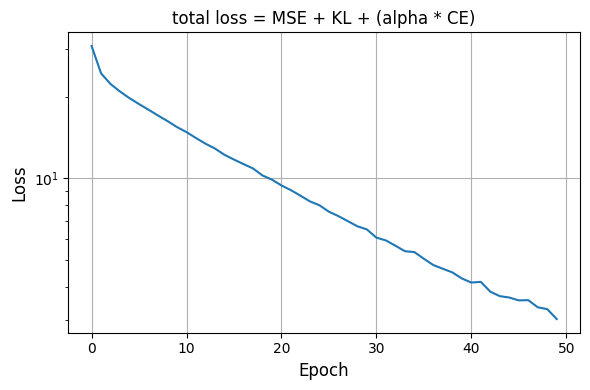

In [9]:
gpv.plot_loss_function(total_loss, title='total loss = MSE + KL + (alpha * CE)', logScale=True, fig_size=(6, 4))

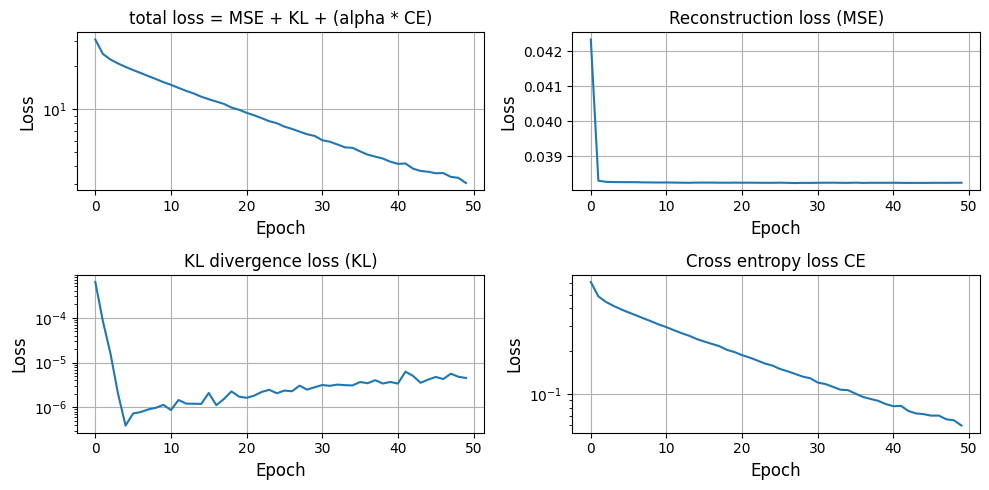

In [10]:
gpv.plot_loss_functions(total_loss, total_reco, total_kl, total_ce, fig_size=(10, 5))

# Checks on training sample (sanity checks and model validation)

In [11]:
# switch to evaluation mode
model.eval()

GMVAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=296, out_features=148, bias=True)
    (fc2): Linear(in_features=148, out_features=74, bias=True)
    (classifier): Linear(in_features=74, out_features=3, bias=True)
    (mu): Linear(in_features=74, out_features=8, bias=True)
    (logvar): Linear(in_features=74, out_features=8, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=8, out_features=74, bias=True)
    (fc2): Linear(in_features=74, out_features=148, bias=True)
    (fc3): Linear(in_features=148, out_features=296, bias=True)
  )
)

## Underfitting test: reconstruction error

 $ \ll 0.1 \rightarrow$ good

 $ \gg 0.5 \rightarrow$ underfitting -> add more layers or increase z_dim (or normalization bug)

In [12]:
x_train = torch.tensor(X_train).float().to(device)
y_train = torch.tensor(Y_train).long().to(device)
gpv.reconstruction_error(model, x_train, y_train)

Overall MSE: 0.038243
 Neutron Reconstruction Error: 0.040892
 Gamma Reconstruction Error: 0.040332
 Pile-up Reconstruction Error: 0.033506


## Confusion Matrix

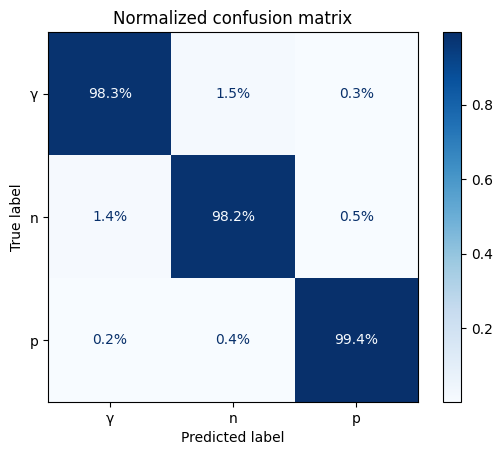

In [13]:
gpv.plot_confusion_matrix(train_loader, model)

## Reconstruction

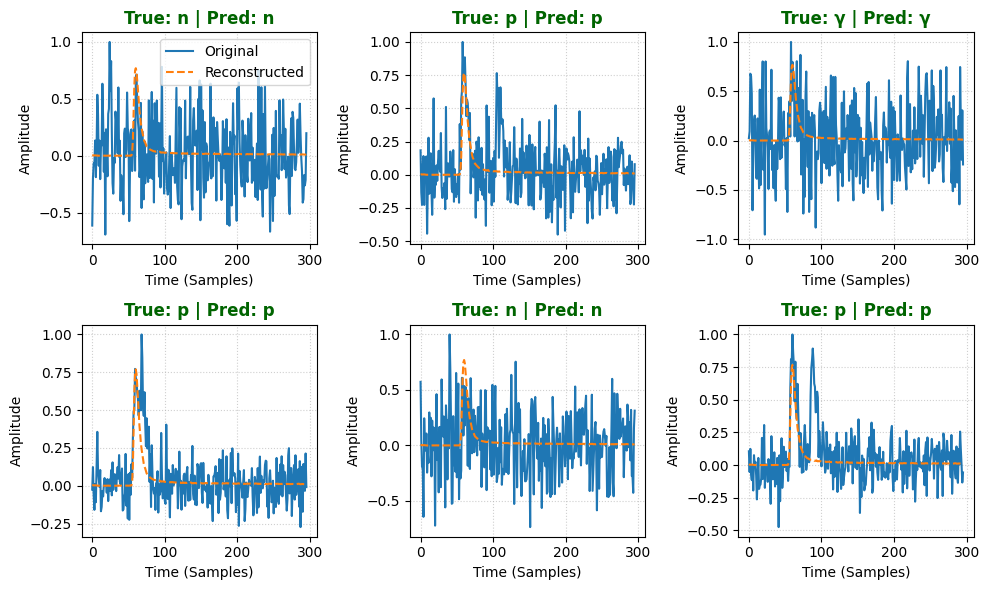

In [14]:
gpv.plot_random_reconstructions(model, train_loader)

# TEST: increwase z_dim = (16, 32); reduce alpha

# Latent Space

/Users/emiliebertholet/Physenv/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/emiliebertholet/Physenv/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/emiliebertholet/Physenv/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


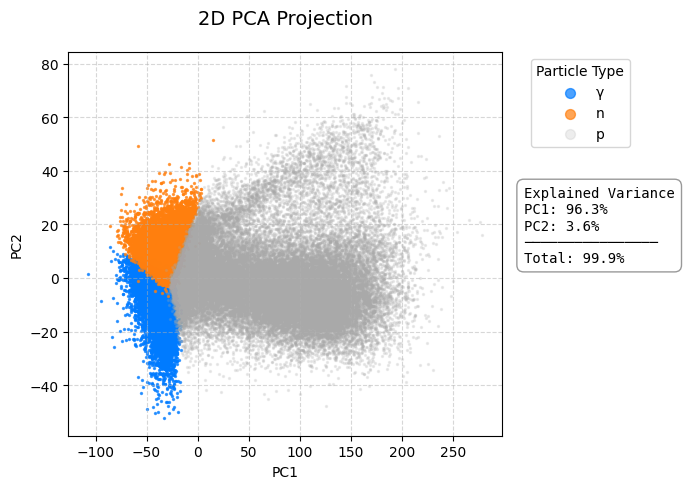

In [15]:
gpv.plot_2d_pca(train_loader, model)

/Users/emiliebertholet/Physenv/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/emiliebertholet/Physenv/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/emiliebertholet/Physenv/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


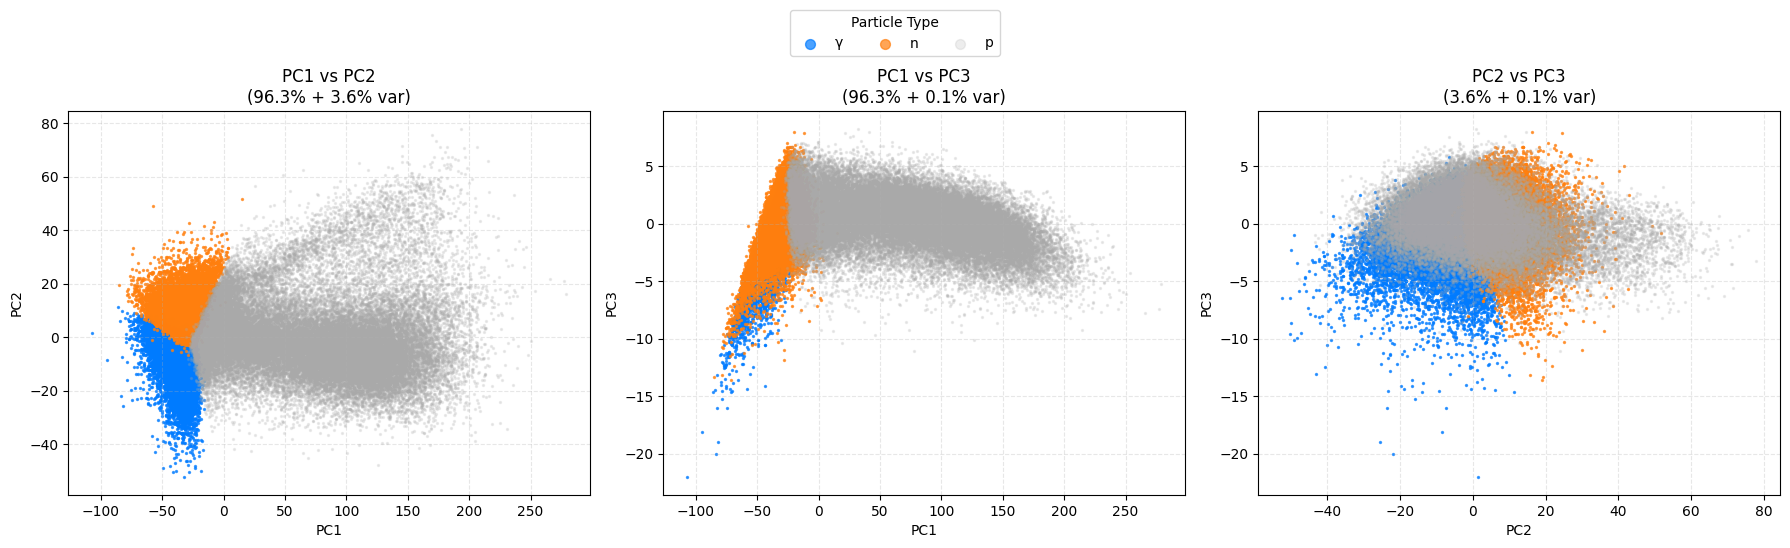

In [16]:
gpv.plot_3d_pca_projections(train_loader, model)

In [17]:
gpv.plot_interactive_3d_pca(train_loader, model) # opens a browser

/Users/emiliebertholet/Physenv/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/emiliebertholet/Physenv/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/emiliebertholet/Physenv/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


# Checks on test sample 

In [18]:
print('Test Sample')
x_test = torch.tensor(X_test).float().to(device)
y_test = torch.tensor(Y_test).long().to(device)
gpv.reconstruction_error(model, x_train, y_train)
print('\nTraining Sample for comparison')
x_train = torch.tensor(X_train).float().to(device)
y_train = torch.tensor(Y_train).long().to(device)
gpv.reconstruction_error(model, x_train, y_train)

Test Sample
Overall MSE: 0.038243
 Neutron Reconstruction Error: 0.040892
 Gamma Reconstruction Error: 0.040333
 Pile-up Reconstruction Error: 0.033506

Training Sample for comparison
Overall MSE: 0.038243
 Neutron Reconstruction Error: 0.040892
 Gamma Reconstruction Error: 0.040333
 Pile-up Reconstruction Error: 0.033506


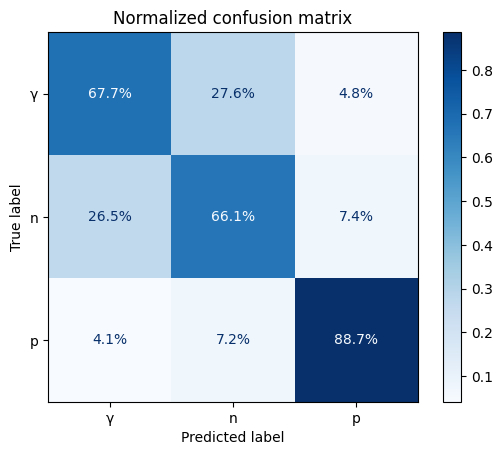

In [19]:
gpv.plot_confusion_matrix(test_loader, model)

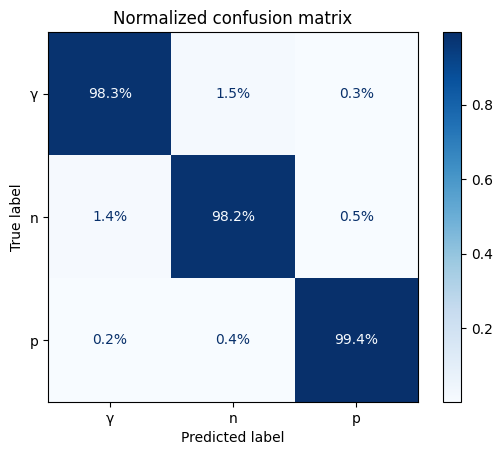

In [20]:
gpv.plot_confusion_matrix(train_loader, model)

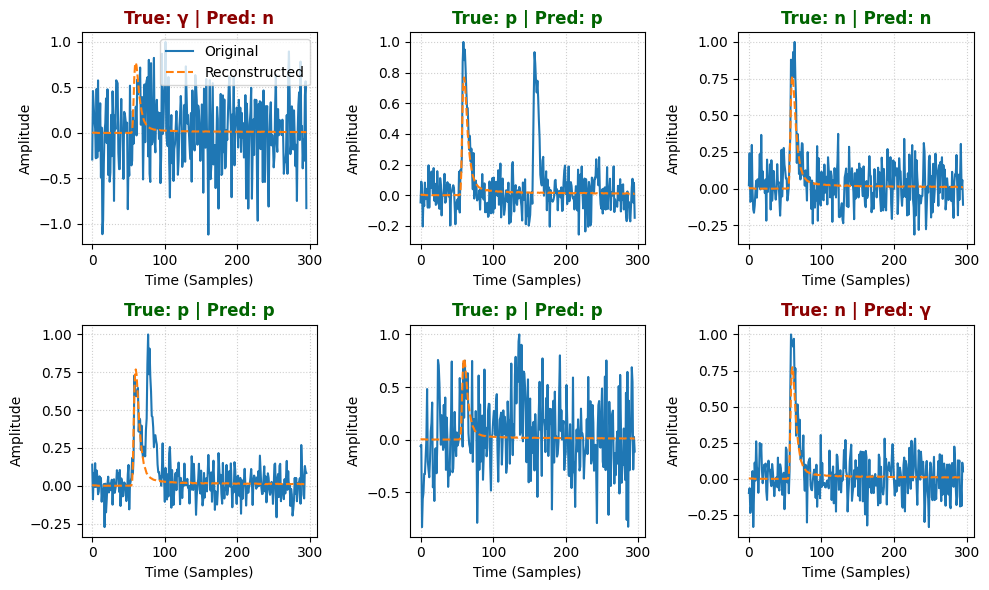

In [21]:
gpv.plot_random_reconstructions(model, test_loader)

/Users/emiliebertholet/Physenv/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning:

divide by zero encountered in matmul

/Users/emiliebertholet/Physenv/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning:

overflow encountered in matmul

/Users/emiliebertholet/Physenv/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning:

invalid value encountered in matmul



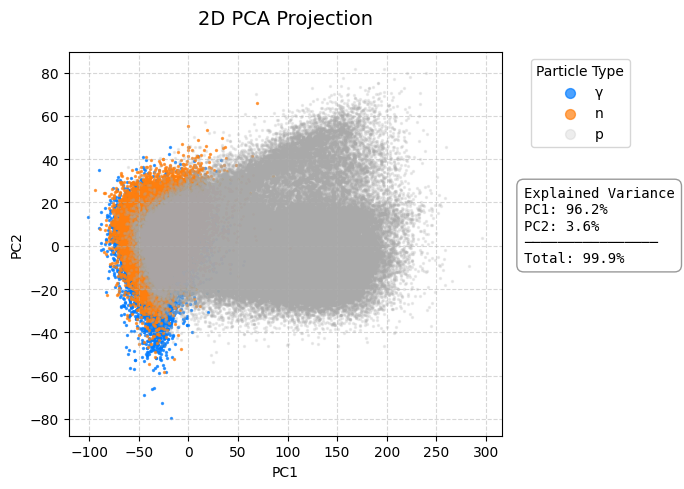

In [22]:
gpv.plot_2d_pca(test_loader, model)

In [23]:
gpv.plot_interactive_3d_pca(test_loader, model)

/Users/emiliebertholet/Physenv/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning:

divide by zero encountered in matmul

/Users/emiliebertholet/Physenv/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning:

overflow encountered in matmul

/Users/emiliebertholet/Physenv/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning:

invalid value encountered in matmul



/Users/emiliebertholet/Physenv/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning:

divide by zero encountered in matmul

/Users/emiliebertholet/Physenv/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning:

overflow encountered in matmul

/Users/emiliebertholet/Physenv/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning:

invalid value encountered in matmul



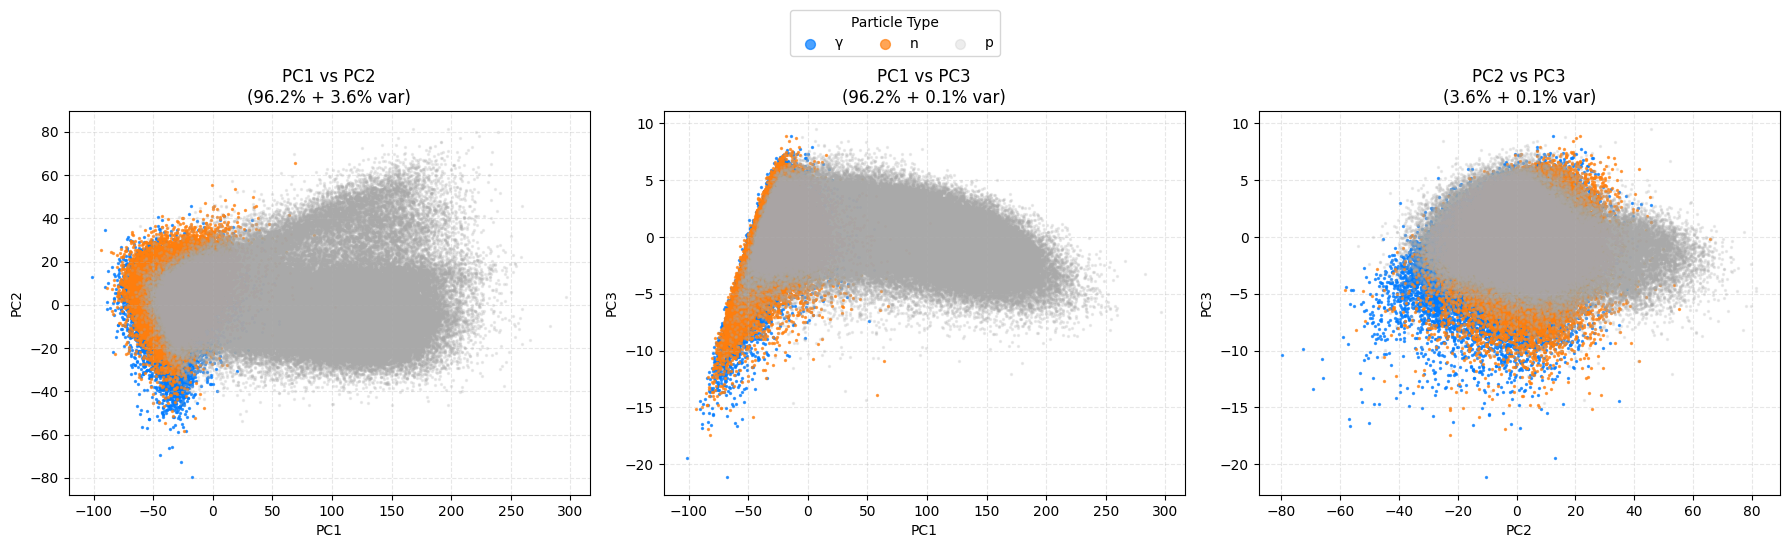

In [25]:
gpv.plot_3d_pca_projections(test_loader, model)